In [1]:
%run additional.ipynb

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
pandas.set_option('display.max_colwidth', 120)

In [103]:
PROFILE = 'ssh-ipy'

# HLT2 nbody classification

did preselections:

* any sv.n, 
* any sv.minpt
* sv.nlt16 < 2

## Training channels (read data)

We will use just 11114001, 11296013, 11874042, 12103035, 13246001, 13264021

In [4]:
sig_train_modes_names = [11114001, 11296013, 11874042, 12103035, 13246001, 13264021]
bck_train_mode_name = 30000000
sig_train_files = ['mod_{}.csv'.format(name) for name in sig_train_modes_names]
bck_train_files = 'mod_30000000.csv'
folder = "datasets/prepared_hlt_body/"

In [5]:
# concat all signal data
if not os.path.exists(folder + 'signal_hlt2.csv'):
    concat_files(folder, sig_train_files, os.path.join(folder , 'signal_hlt2.csv'))

In [6]:
signal_data = pandas.read_csv(os.path.join(folder , 'signal_hlt2.csv'), sep='\t')
bck_data = pandas.read_csv(os.path.join(folder , bck_train_files), sep='\t')

In [7]:
signal_data.columns

Index([u'unique', u'mode', u'event_number', u'sv_number', u'pass_2body', u'pass_nbody', u'signal', u'sumpt', u'm', u'mcor', u'ipchi2', u'chi2', u'sumipchi2', u'fdr', u'nlt16', u'minpt', u'eta', u'pt', u'nmu', u'n', u'fdchi2', u'maxtchi2', u'ngood', u'nmu1', u'mupt', u'n1trk', u'sig', u'idx'], dtype='object')

## Counting events and svrs,
that passed **L0** and **GoodGenB** preselection (this data was generated by skim)

In [8]:
print 'Signal', statistic_length(signal_data)
print 'Bck', statistic_length(bck_data)

Signal {'SVR': 12367085, 'Events': 166059}
Bck {'SVR': 408147, 'Events': 38035}


In [9]:
total_bck_events = statistic_length(bck_data)['Events'] + empty_events[bck_train_mode_name]
total_signal_events_by_mode = dict()
for mode in sig_train_modes_names:
    total_signal_events_by_mode[mode] = statistic_length(signal_data[signal_data['mode'] == mode])['Events'] + empty_events[mode]

### events distribution by mode

In [10]:
print 'Bck:', total_bck_events
'Signal:', total_signal_events_by_mode

Bck: 111306


('Signal:',
 {11114001: 61102,
  11296013: 17149,
  11874042: 3942,
  12103035: 25250,
  13246001: 37313,
  13264021: 25165})

## Define variables

In [11]:
variables = ["n", "mcor", "chi2", "eta", "fdchi2", "minpt", "nlt16", "ipchi2", "n1trk", "sumpt"]

## Counting events and svrs,

which passed **pass_nbody** (equivalent Mike's preselections for nbody selection)

In [12]:
# hlt2 nbody selection
signal_data = signal_data[(signal_data['pass_nbody'] == 1) & (signal_data['mcor'] <= 10e3)]
bck_data = bck_data[(bck_data['pass_nbody'] == 1) & (bck_data['mcor'] <= 10e3)]

In [13]:
print 'Signal', statistic_length(signal_data)
print 'Bck', statistic_length(bck_data)

Signal {'SVR': 960600, 'Events': 150566}
Bck {'SVR': 21868, 'Events': 9664}


In [14]:
total_signal_events_by_mode_presel = dict()
for mode in sig_train_modes_names:
    total_signal_events_by_mode_presel[mode] = statistic_length(signal_data[signal_data['mode'] == mode])['Events']
total_bck_events_presel = statistic_length(bck_data)['Events']

### events distribution by mode

In [15]:
print 'Bck:', total_bck_events_presel
'Signal:', total_signal_events_by_mode_presel

Bck: 9664


('Signal:',
 {11114001: 53105,
  11296013: 16256,
  11874042: 3290,
  12103035: 21498,
  13246001: 33807,
  13264021: 22610})

In [16]:
signal_data.head()

,unique,mode,event_number,sv_number,pass_2body,pass_nbody,signal,sumpt,m,mcor,...,nmu,n,fdchi2,maxtchi2,ngood,nmu1,mupt,n1trk,sig,idx
1,11114001_0,11114001,0,1,1,1,1,6912.10,2806.110,4168.77,...,1,2,9653.910,1.20832,2,1,2972.750,2,1,1
2,11114001_0,11114001,0,2,1,1,1,3731.68,728.895,4429.24,...,2,2,7424.620,1.58733,2,2,2972.750,1,1,2
3,11114001_0,11114001,0,3,1,1,1,4698.27,1249.280,2144.50,...,1,2,1382.720,1.58733,2,1,758.924,1,1,3
5,11114001_1,11114001,1,1,1,1,1,4003.36,3530.930,4651.29,...,1,2,1102.850,1.20808,2,1,2611.970,2,1,1
9,11114001_1,11114001,1,5,1,1,1,2145.67,1520.500,2266.15,...,1,2,868.049,1.35907,2,1,1137.010,2,1,5


## Prepare train/test splitting

Divide events which passed alll preselections into two equal parts randomly

In [17]:
ds_train_signal, ds_train_bck, ds_test_signal, ds_test_bck = prepare_data(signal_data, bck_data, 'unique')

### train: counting events and svrs

In [18]:
print 'Signal', statistic_length(ds_train_signal)
print 'Bck', statistic_length(ds_train_bck)

Signal {'SVR': 479851, 'Events': 75283}
Bck {'SVR': 10759, 'Events': 4832}


In [19]:
train = pandas.concat([ds_train_bck, ds_train_signal])

### test: counting events and svrs

In [20]:
print 'Signal', statistic_length(ds_test_signal)
print 'Bck', statistic_length(ds_test_bck)

Signal {'SVR': 480749, 'Events': 75283}
Bck {'SVR': 11109, 'Events': 4832}


In [21]:
test = pandas.concat([ds_test_bck, ds_test_signal])

## Define all total events in test samples
(which passed just l0 and goodgenB) using also empty events. Suppose that events which didn't pass **pass_nboby** also were equal randomly divided into training and test samples 

In [22]:
total_test_bck_events = (total_bck_events - total_bck_events_presel) // 2 + statistic_length(ds_test_bck)['Events']
total_test_signal_events = dict()
for mode in sig_train_modes_names:
    total_not_passed_signal = total_signal_events_by_mode[mode] - total_signal_events_by_mode_presel[mode]
    total_test_signal_events[mode] = total_not_passed_signal // 2 + \
        statistic_length(ds_test_signal[ds_test_signal['mode'] == mode])['Events']

In [23]:
print 'Bck total test events:', total_test_bck_events
'Signal total test events:', total_test_signal_events

Bck total test events: 55653


('Signal total test events:',
 {11114001: 30533,
  11296013: 8630,
  11874042: 1950,
  12103035: 12682,
  13246001: 18627,
  13264021: 12537})

In [24]:
import cPickle
if os.path.exists('models/prunned.pkl'):
    with open('models/prunned.pkl', 'r') as file_pr:
        estimators = cPickle.load(file_pr)

# Matrixnet training

In [27]:
from rep_ef.estimators import MatrixNetSkyGridClassifier

### Base model with 5000 trees

In [28]:
ef_base = MatrixNetSkyGridClassifier(train_features=variables, user_name='antares',
                                     connection='skygrid',
                                     iterations=5000, sync=False)
ef_base.fit(train, train['signal'])

MatrixNetSkyGridClassifier(auto_stop=None, baseline_feature=None,
              command_line_params=None, connection='skygrid',
              dump_filename=None, features_sample_rate_per_iteration=1.0,
              intervals=64, iterations=5000, max_features_per_iteration=6,
              regularization=0.01, sync=False,
              train_features=['n', 'mcor', 'chi2', 'eta', 'fdchi2', 'minpt', 'nlt16', 'ipchi2', 'n1trk', 'sumpt'],
              training_fraction=0.5, user_name='antares')

### Base BBDT model

In [29]:
special_b = {
'n': [2.5, 3.5],
'mcor': [2000,3000,4000,5000,7500],  # I want to remove splits too close the the B mass as I was looking in simulation and this could distort the mass peak (possibly)
'chi2': [1,2.5,5,7.5,10,100],  # I also propose we add a cut to the pre-selection of chi2 < 1000.  I don't want to put in splits at too small values here b/c these type of inputs are never modeled quite right in the simulation (they always look a bit more smeared in data).
'sumpt': [3000,4000,5000,6000,7500,9000,12e3,23e3,50e3],  # I am happy with the MN splits here (these are almost "as is" from modify-6)
'eta': [2.5,3,3.75,4.25,4.5], # Close to MN.  
'fdchi2': [33,125,350,780,1800,5000,10000],  # I want to make the biggest split 10e3 because in the simulated events there is pretty much only BKGD above 40e3 but we don't want the BDT to learn to kill these as new particles would live here.   Otherwise I took the MN splits and modified the first one (the first one is 5sigma now).
'minpt': [350,500,750,1500,3000,5000],   # let's make 500 the 2nd split so that this lines up with the HLT1 SVs.
'nlt16': [0.5],
'ipchi2': [8,26,62,150,500,1000],  # I also propose we add a cut of IP chi2 < 5000 as it's all background out there.  
'n1trk': [0.5, 1.5, 2.5, 3.5]
}

ef_base_bbdt = MatrixNetSkyGridClassifier(train_features=variables, user_name='antares',
                                          connection='skygrid',
                                          iterations=5000, sync=False, intervals=special_b)
ef_base_bbdt.fit(train, train['signal'])

MatrixNetSkyGridClassifier(auto_stop=None, baseline_feature=None,
              command_line_params=None, connection='skygrid',
              dump_filename=None, features_sample_rate_per_iteration=1.0,
              intervals={'sumpt': [3000, 4000, 5000, 6000, 7500, 9000, 12000.0, 23000.0, 50000.0], 'eta': [2.5, 3, 3.75, 4.25, 4.5], 'minpt': [350, 500, 750, 1500, 3000, 5000], 'chi2': [1, 2.5, 5, 7.5, 10, 100], 'n1trk': [0.5, 1.5, 2.5, 3.5], 'nlt16': [0.5], 'mcor': [2000, 3000, 4000, 5000, 7500], 'fdchi2': [33, 125, 350, 780, 1800, 5000, 10000], 'ipchi2': [8, 26, 62, 150, 500, 1000], 'n': [2.5, 3.5]},
              iterations=5000, max_features_per_iteration=6,
              regularization=0.01, sync=False,
              train_features=['n', 'mcor', 'chi2', 'eta', 'fdchi2', 'minpt', 'nlt16', 'ipchi2', 'n1trk', 'sumpt'],
              training_fraction=0.5, user_name='antares')

### BBDT-5, 6

In [30]:
ef_base_bbdt5 = MatrixNetSkyGridClassifier(train_features=variables, user_name='antares',
                                          connection='skygrid',
                                          iterations=5000, sync=False, intervals=5)
ef_base_bbdt5.fit(train, train['signal'])

ef_base_bbdt6 = MatrixNetSkyGridClassifier(train_features=variables, user_name='antares',
                                          connection='skygrid',
                                          iterations=5000, sync=False, intervals=6)
ef_base_bbdt6.fit(train, train['signal'])

MatrixNetSkyGridClassifier(auto_stop=None, baseline_feature=None,
              command_line_params=None, connection='skygrid',
              dump_filename=None, features_sample_rate_per_iteration=1.0,
              intervals=6, iterations=5000, max_features_per_iteration=6,
              regularization=0.01, sync=False,
              train_features=['n', 'mcor', 'chi2', 'eta', 'fdchi2', 'minpt', 'nlt16', 'ipchi2', 'n1trk', 'sumpt'],
              training_fraction=0.5, user_name='antares')

# Pruning

In [31]:
from rep.data import LabeledDataStorage
from rep.report import ClassificationReport
report = ClassificationReport({'base': ef_base}, LabeledDataStorage(test, test['signal']))

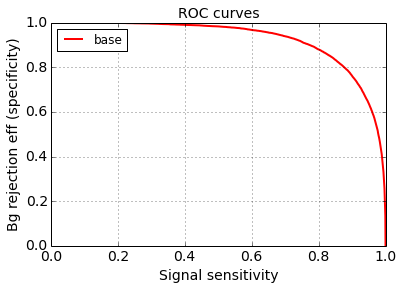

In [32]:
report.roc()

## Minimize log_loss
он же BinomialDeviance

In [33]:
%run pruning.py

### Training sample is cut to be aliquot 8

In [34]:
new_trainlen = (len(train) // 8) * 8
trainX = train[ef_base.features][:new_trainlen].values
trainY = train['signal'][:new_trainlen].values 
trainW = numpy.ones(len(trainY))
trainW[trainY == 0] *= sum(trainY) / sum(1 - trainY)

In [35]:
new_features, new_formula_mx, new_classifier = select_trees(trainX, trainY, sample_weight=trainW,
                                                            initial_classifier=ef_base,
                                                            iterations=100, n_candidates=100, 
                                                            learning_rate=0.1, regularization=50.)

0 1.61639046851 0.864149179375
1 1.55188342817 0.871006756536
2 1.4974419247 0.871931415195
3 1.45063957562 0.871257415717
4 1.40839869622 0.882903045944
5 1.37366046126 0.88787704316
6 1.34072767041 0.887003202722
7 1.31150104365 0.893023018467
8 1.28379095058 0.896263184453
9 1.25809114034 0.898190409332
10 1.23593045848 0.89788161298
11 1.21672628163 0.899391156041
12 1.19916894981 0.901041763496
13 1.18285986055 0.900870790499
14 1.16821214312 0.901828769835
15 1.15477734313 0.902456983346
16 1.14213029917 0.903531415611
17 1.12974589809 0.904730333043
18 1.11902162756 0.905431320555
19 1.10922459706 0.906217749773
20 1.09967334445 0.907074639763
21 1.09128157517 0.908045647467
22 1.08329445479 0.908310608384
23 1.07526925282 0.909011025167
24 1.06802464375 0.909790861995
25 1.06178926981 0.910268591808
26 1.05538189711 0.910926982288
27 1.04974682021 0.911391242005
28 1.04431160909 0.911875445471
29 1.03922534297 0.912452518835
30 1.03436250836 0.912689445171
31 1.02963139549 0.91

In [36]:
prunned = cPickle.loads(cPickle.dumps(ef_base))
prunned.formula_mx = new_formula_mx

In [100]:
def mode_scheme_fit(train, base, suf, model_file):
    blending_parts = OrderedDict()
    for n_ch, ch in enumerate(sig_train_modes_names):
        temp = FoldingClassifier(base_estimator=base, random_state=11, features=variables, ipc_profile=PROFILE)
        temp_data = train[(train['mode'] == ch) | (train['mode'] == bck_train_mode_name)]
        temp.fit(temp_data, temp_data['signal'])
        blending_parts['ch' + str(n_ch) + suf] = temp
    import cPickle
    with open(model_file, 'w') as f:
        cPickle.dump(blending_parts, f)

def mode_scheme_predict(data, suf, model_file, mode='train'):
    with open(model_file, 'r') as f:
        blending_parts = cPickle.load(f)
    for n_ch, ch in enumerate(sig_train_modes_names):
        temp_name = 'ch' + str(n_ch) + suf
        if mode == 'train':
            temp_key = ((data['mode'] == ch) | (data['mode'] == bck_train_mode_name))
            data.ix[temp_key, temp_name] = blending_parts[temp_name].predict_proba(
                data[temp_key])[:, 1]
            data.ix[~temp_key, temp_name] = blending_parts[temp_name].predict_proba(
                data[~temp_key])[:, 1]
        else:
            data[temp_name] = blending_parts[temp_name].predict_proba(data)[:, 1]

In [101]:
def get_best_svr_by_channel(data, feature_mask, count=1):
    add_events = []
    for id_est, channel in enumerate(sig_train_modes_names):
        train_part = data[(data['mode'] == channel)]
        for num, group in train_part.groupby('unique'):
            index = numpy.argsort(group[feature_mask.format(id_est)].values)[::-1]
            add_events.append(group.iloc[index[:count], :])
    good_events = pandas.concat([data[(data['mode'] == bck_train_mode_name)]] + add_events)
    print len(good_events)
    return good_events

In [104]:
from sklearn.ensemble import RandomForestClassifier
from rep.metaml import FoldingClassifier
base = RandomForestClassifier(n_estimators=500, min_samples_leaf=50, max_depth=6,
                              max_features=7, n_jobs=8)

mode_scheme_fit(train, base, '', 'forest_trick.pkl')
mode_scheme_predict(train, '', 'forest_trick.pkl')
mode_scheme_predict(test, '', 'forest_trick.pkl', mode='test')

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


In [107]:
good_events = get_best_svr_by_channel(train, 'ch{}', 2)
forest_mn = MatrixNetSkyGridClassifier(train_features=variables,
                                     user_name='antares',
                                     connection='skygrid',
                                     iterations=5000, sync=False)
forest_mn.fit(good_events, good_events['signal'])

148864


MatrixNetSkyGridClassifier(auto_stop=None, baseline_feature=None,
              command_line_params=None, connection='skygrid',
              dump_filename=None, features_sample_rate_per_iteration=1.0,
              intervals=64, iterations=5000, max_features_per_iteration=6,
              regularization=0.01, sync=False,
              train_features=['n', 'mcor', 'chi2', 'eta', 'fdchi2', 'minpt', 'nlt16', 'ipchi2', 'n1trk', 'sumpt'],
              training_fraction=0.5, user_name='antares')

In [112]:
forest_mn_bbdt = MatrixNetSkyGridClassifier(train_features=variables,
                                            user_name='antares',
                                             connection='skygrid',
                                             iterations=5000, sync=False, intervals=special_b)
forest_mn_bbdt.fit(good_events, good_events['signal'])

MatrixNetSkyGridClassifier(auto_stop=None, baseline_feature=None,
              command_line_params=None, connection='skygrid',
              dump_filename=None, features_sample_rate_per_iteration=1.0,
              intervals={'sumpt': [3000, 4000, 5000, 6000, 7500, 9000, 12000.0, 23000.0, 50000.0], 'eta': [2.5, 3, 3.75, 4.25, 4.5], 'minpt': [350, 500, 750, 1500, 3000, 5000], 'chi2': [1, 2.5, 5, 7.5, 10, 100], 'n1trk': [0.5, 1.5, 2.5, 3.5], 'nlt16': [0.5], 'mcor': [2000, 3000, 4000, 5000, 7500], 'fdchi2': [33, 125, 350, 780, 1800, 5000, 10000], 'ipchi2': [8, 26, 62, 150, 500, 1000], 'n': [2.5, 3.5]},
              iterations=5000, max_features_per_iteration=6,
              regularization=0.01, sync=False,
              train_features=['n', 'mcor', 'chi2', 'eta', 'fdchi2', 'minpt', 'nlt16', 'ipchi2', 'n1trk', 'sumpt'],
              training_fraction=0.5, user_name='antares')

In [116]:
new_trainlen = (len(good_events) // 8) * 8
trainX = good_events[forest_mn.features][:new_trainlen].values
trainY = good_events['signal'][:new_trainlen].values 
trainW = numpy.ones(len(trainY))
trainW[trainY == 0] *= sum(trainY) / sum(1 - trainY)

In [143]:
len(train), len(good_events)

(490610, 148864)

In [117]:
new_features_f, new_formula_mx_f, new_classifier_f = select_trees(trainX, trainY, sample_weight=trainW,
                                                                initial_classifier=forest_mn,
                                                                iterations=100, n_candidates=100, 
                                                                learning_rate=0.1, regularization=50.)

0 1.59878247354 0.898267058314
1 1.51376874775 0.923562775721
2 1.44079443049 0.924933289748
3 1.3805166538 0.926697044996
4 1.32495882539 0.927486156871
5 1.27496922824 0.929864337647
6 1.23062960925 0.933785251222
7 1.19300866229 0.933685420934
8 1.15761858181 0.934627903387
9 1.12736800412 0.935328811146
10 1.0991202171 0.935250788258
11 1.07445225558 0.936354042668
12 1.05126925344 0.937850097817
13 1.03058754558 0.938862143141
14 1.011693557 0.939935307133
15 0.994375772612 0.939972899881
16 0.978284559854 0.940253851797
17 0.963552829217 0.94151909765
18 0.95009519394 0.942402605293
19 0.937824257337 0.943313473644
20 0.925258705091 0.943963868293
21 0.914464860855 0.944279791601
22 0.904148147213 0.94469312103
23 0.894715951762 0.945032701158
24 0.885681679521 0.945655614969
25 0.877518873326 0.946299568954
26 0.869470989835 0.947021607744
27 0.862325731184 0.947294104017
28 0.85581607304 0.947788591194
29 0.849038920939 0.948225310934
30 0.842894270099 0.948501071958
31 0.83709

In [118]:
prunned_f = cPickle.loads(cPickle.dumps(forest_mn))
prunned_f.formula_mx = new_formula_mx_f

In [120]:
estimators = {'base MN': ef_base, 'BBDT MN-6': ef_base_bbdt6, 'BBDT MN-5': ef_base_bbdt5,
              'BBDT MN special': ef_base_bbdt,
              'Prunned MN': prunned, 'base MN + forest': forest_mn,
              'BBDT MN special + forest': forest_mn_bbdt, 'Prunned MN + forest': prunned_f}

In [121]:
import cPickle
with open('models/prunned.pkl', 'w') as file_pr:
    cPickle.dump(estimators, file_pr)

## Calculate thresholds on classifiers

In [122]:
thresholds = dict()
test_bck = test[test['signal'] == 0]
RATE = [2500., 4000.]
events_pass = dict()
for name, cl in estimators.items():
    prob = cl.predict_proba(test_bck)
    thr, result = calculate_thresholds(test_bck, prob, total_test_bck_events, rates=RATE)
    for rate, val in result.items():
        events_pass['{}-{}'.format(rate, name)] = val[1]
    thresholds[name] = thr
    print name, result

BBDT MN-6 {4000.0: (0.99402680780929342, 222, 0.00398900328823244), 2500.0: (0.99595672446060457, 139, 0.002497619175965357)}
BBDT MN-5 {4000.0: (0.99425757263704562, 222, 0.00398900328823244), 2500.0: (0.99628784046073426, 139, 0.002497619175965357)}
Prunned MN {4000.0: (0.76591901044032684, 222, 0.00398900328823244), 2500.0: (0.81966655622937423, 139, 0.002497619175965357)}
BBDT MN special + forest {4000.0: (0.9804137431800608, 222, 0.00398900328823244), 2500.0: (0.98829762728883797, 139, 0.002497619175965357)}
Prunned MN + forest {4000.0: (0.7291955536845629, 222, 0.00398900328823244), 2500.0: (0.81979088052929106, 139, 0.002497619175965357)}
BBDT MN special {4000.0: (0.99441421391844975, 222, 0.00398900328823244), 2500.0: (0.99615994806063501, 139, 0.002497619175965357)}
base MN + forest {4000.0: (0.97825892637449507, 222, 0.00398900328823244), 2500.0: (0.98666907201136622, 139, 0.002497619175965357)}
base MN {4000.0: (0.99410103269102013, 222, 0.00398900328823244), 2500.0: (0.9961

## Final efficiencies for each mode

In [123]:
train_modes_eff, statistic = result_statistic(estimators, sig_train_modes_names, 
                                              test[test['signal'] == 1],
                                              thresholds, RATE, total_test_signal_events)

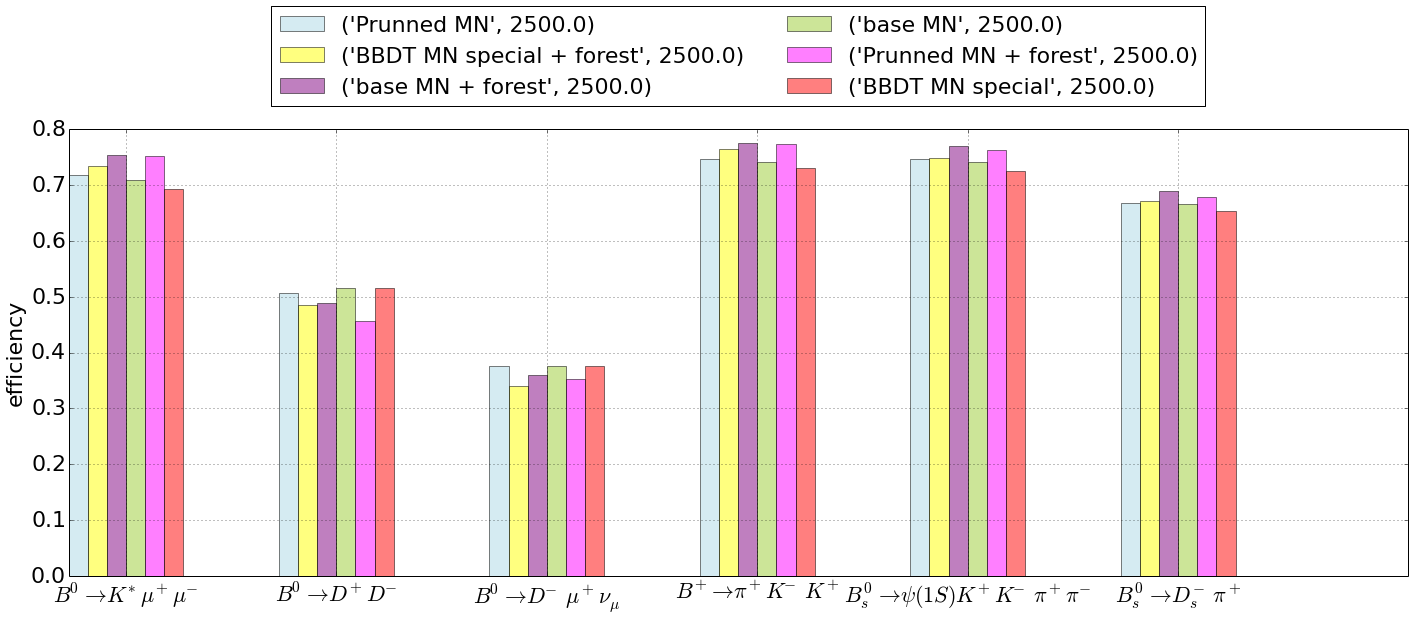

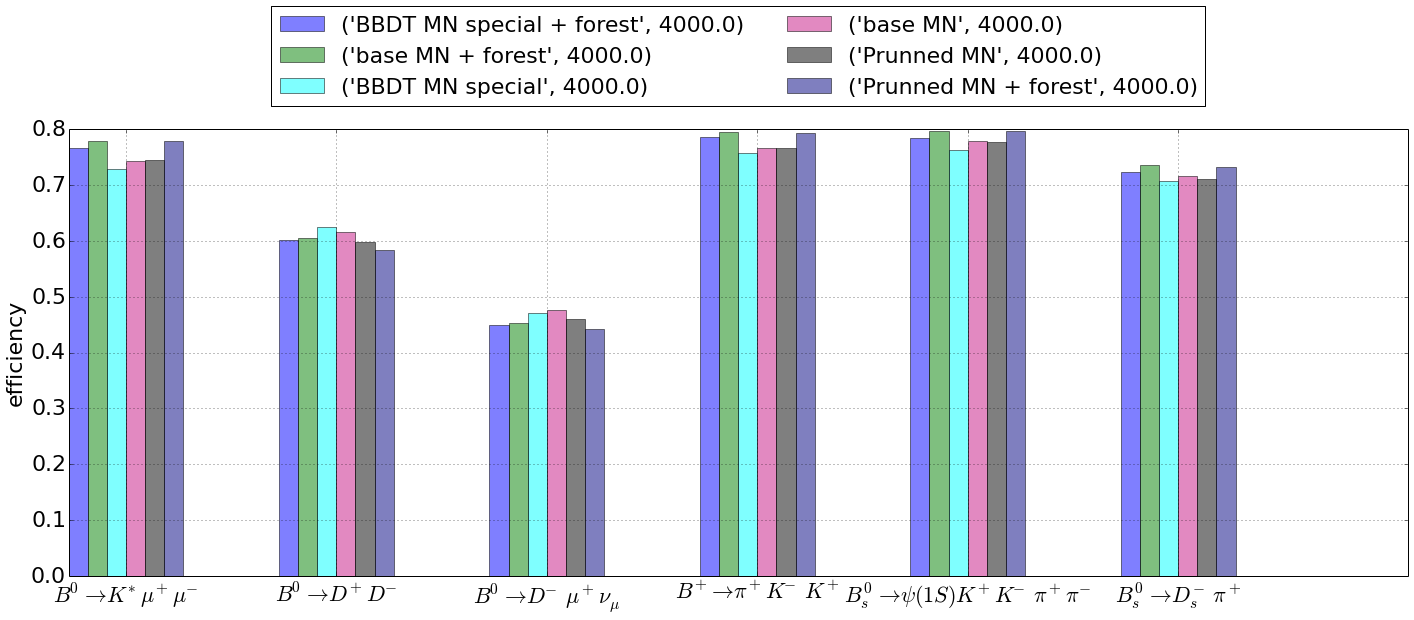

In [153]:
from rep.plotting import BarComparePlot
xticks_labels = ['$B^0 \\to K^*\mu^+\mu^-$', "$B^0 \\to D^+D^-$", "$B^0 \\to D^- \mu^+ \\nu_{\mu}$", 
                 '$B^+ \\to \pi^+ K^-K^+$', '$B^0_s \\to \psi(1S) K^+K^-\pi^+\pi^-$', '$B^0_s \\to D_s^-\pi^+$']
for r in RATE:
    new_dict = [] 
    for key, val in train_modes_eff.iteritems():
        if (key[0] in {'base MN', 'Prunned MN', 'BBDT MN special', 
                       'base MN + forest', 'Prunned MN + forest', 'BBDT MN special + forest'}) and r == key[1]:
            new_dict.append((key, val))
    new_dict = dict(new_dict)        
    BarComparePlot(new_dict).plot(new_plot=True, figsize=(24, 8), ylabel='efficiency', fontsize=22)
    xticks(3 + 11 * numpy.arange(6), xticks_labels, rotation=0)
    lgd = legend(bbox_to_anchor=(0.5, 1.3), loc='upper center', ncol=2, fontsize=22)
# plt.savefig('hlt2-experiments.pdf' , format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

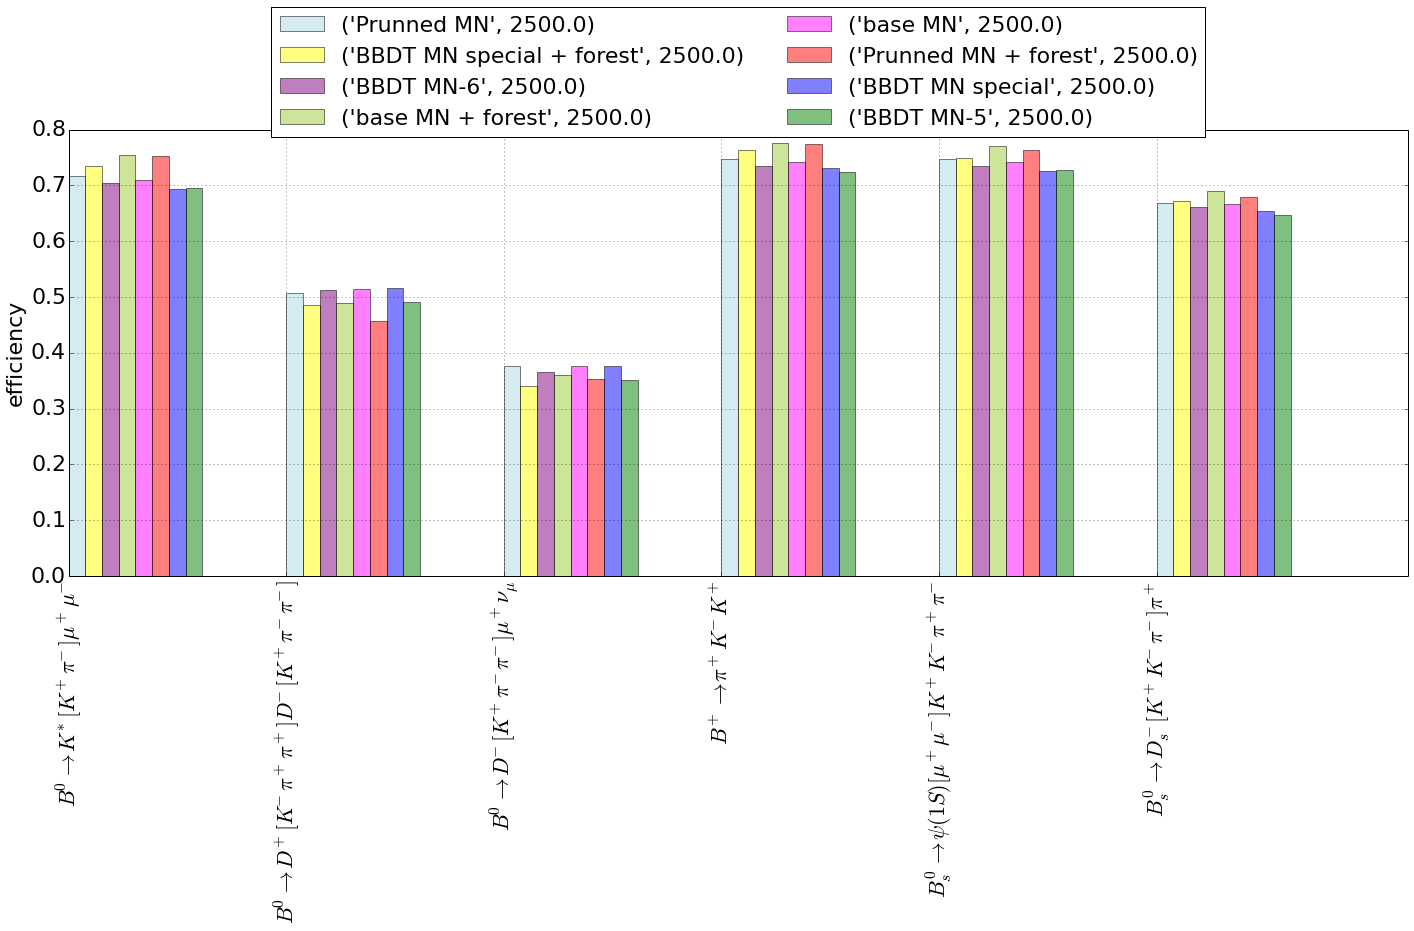

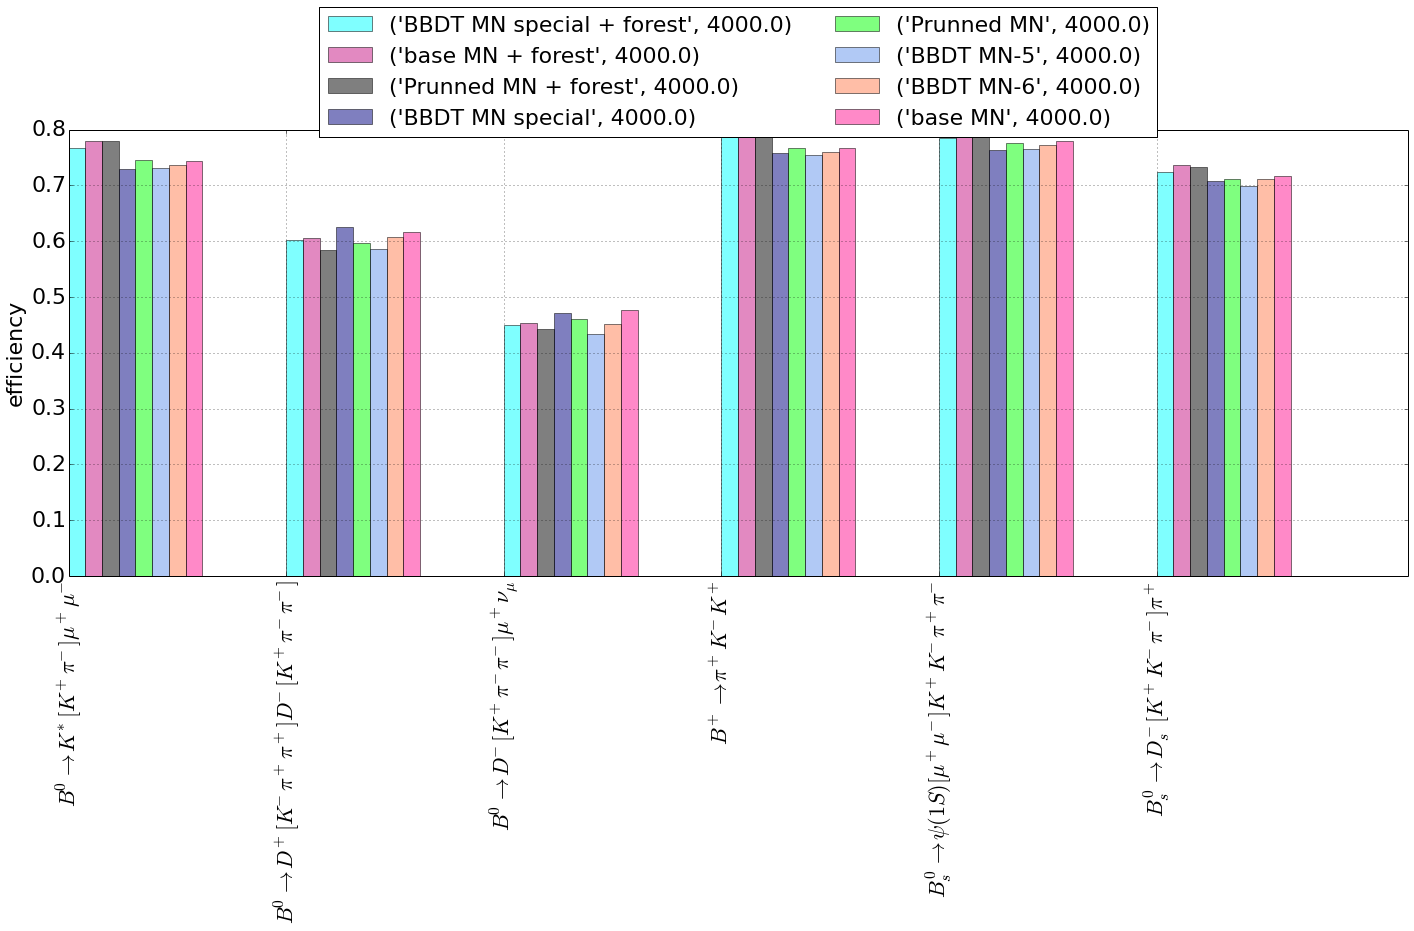

In [125]:
from rep.plotting import BarComparePlot
for r in RATE:
    new_dict = [] 
    for key, val in train_modes_eff.iteritems():
        if r == key[1]:
            new_dict.append((key, val))
    new_dict = dict(new_dict)        
    BarComparePlot(new_dict).plot(new_plot=True, figsize=(24, 8), ylabel='efficiency', fontsize=22)
    lgd = legend(bbox_to_anchor=(0.5, 1.3), loc='upper center', ncol=2, fontsize=22)
# plt.savefig('hlt2-experiments.pdf' , format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

## Classification report using events

In [126]:
plots = OrderedDict()
for key, value in estimators.items():
    plots[key] = plot_roc_events(value, test[test['signal'] == 1], test[test['signal'] == 0], key)

BBDT MN-6 AUC: 0.948787065058
BBDT MN-5 AUC: 0.946395911938
Prunned MN AUC: 0.954561135933
BBDT MN special + forest AUC: 0.956099303177
Prunned MN + forest AUC: 0.957158203039
BBDT MN special AUC: 0.952332233169
base MN + forest AUC: 0.959967543942
base MN AUC: 0.955959310671


In [127]:
bbdt_plots = plots.copy()
bbdt_plots.pop('Prunned MN')
bbdt_plots.pop('Prunned MN + forest')

(array([ 0.        ,  0.        ,  0.        , ...,  0.99958609,
         0.99979305,  1.        ]),
 array([  1.54235301e-05,   3.71280728e-05,   4.34090853e-05, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00]))

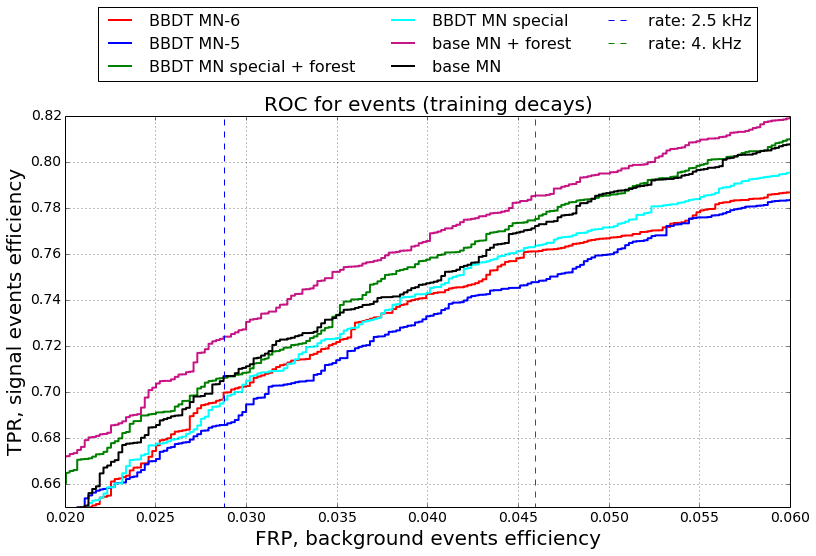

In [128]:
from rep.plotting import FunctionsPlot
FunctionsPlot(bbdt_plots).plot(new_plot=True, xlim=(0.02, 0.06), ylim=(0.65, 0.82))
plot([1. * events_pass['2500.0-base MN'] / statistic_length(ds_test_bck)['Events']] * 2, 
     [0., 1], 'b--', label='rate: 2.5 kHz')
plot([1. * events_pass['4000.0-base MN'] / statistic_length(ds_test_bck)['Events']] * 2, 
     [0., 1], 'g--', label='rate: 4. kHz')
lgd = legend(loc='upper center', fontsize=16, bbox_to_anchor=(0.5, 1.3), ncol=3)
title('ROC for events (training decays)', fontsize=20)
xlabel('FRP, background events efficiency', fontsize=20)
ylabel('TPR, signal events efficiency', fontsize=20)

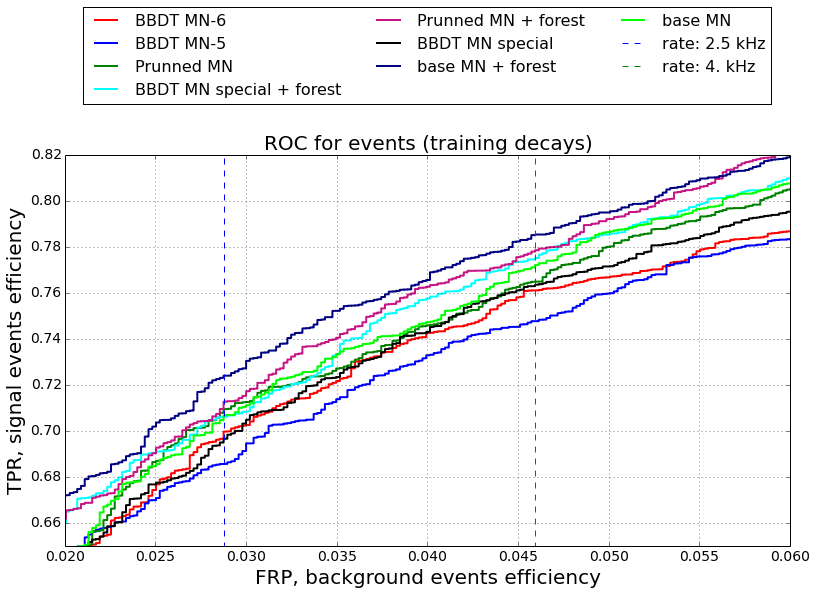

In [130]:
from rep.plotting import FunctionsPlot
FunctionsPlot(plots).plot(new_plot=True, xlim=(0.02, 0.06), ylim=(0.65, 0.82))
plot([1. * events_pass['2500.0-base MN'] / statistic_length(ds_test_bck)['Events']] * 2, 
     [0., 1], 'b--', label='rate: 2.5 kHz')
plot([1. * events_pass['4000.0-base MN'] / statistic_length(ds_test_bck)['Events']] * 2, 
     [0., 1], 'g--', label='rate: 4. kHz')
lgd = legend(loc='upper center', fontsize=16, bbox_to_anchor=(0.5, 1.4), ncol=3)
title('ROC for events (training decays)', fontsize=20)
xlabel('FRP, background events efficiency', fontsize=20)
ylabel('TPR, signal events efficiency', fontsize=20)

# all channels efficiencies

In [131]:
from collections import defaultdict
all_channels = []
efficiencies = defaultdict(OrderedDict)
for mode in empty_events.keys():
    if mode in set(sig_train_modes_names) or mode == bck_train_mode_name:
        continue
    df = pandas.read_csv(os.path.join(folder , 'mod_{}.csv'.format(mode)), sep='\t')
    if len(df) <= 0:
        continue
    total_events = statistic_length(df)['Events'] + empty_events[mode]
    df = df[(df['pass_nbody'] == 1) & (df['mcor'] <= 10e3)]
    passed_events = statistic_length(df)['Events']
    all_channels.append(df)
    for name, cl in estimators.items():
        prob = cl.predict_proba(df)
        for rate, thresh in thresholds[name].items():
            eff = final_eff_for_mode(df, prob, total_events, thresh)
            latex_name = '$' + Samples[str(mode)]['root'].replace("#", "\\") + '$'
            efficiencies[(name, rate)][latex_name] = eff

In [132]:
for key, val in efficiencies.items():
    for key_2, val_2 in val.items():
        if val_2 <= 0.1:
            efficiencies[key].pop(key_2)

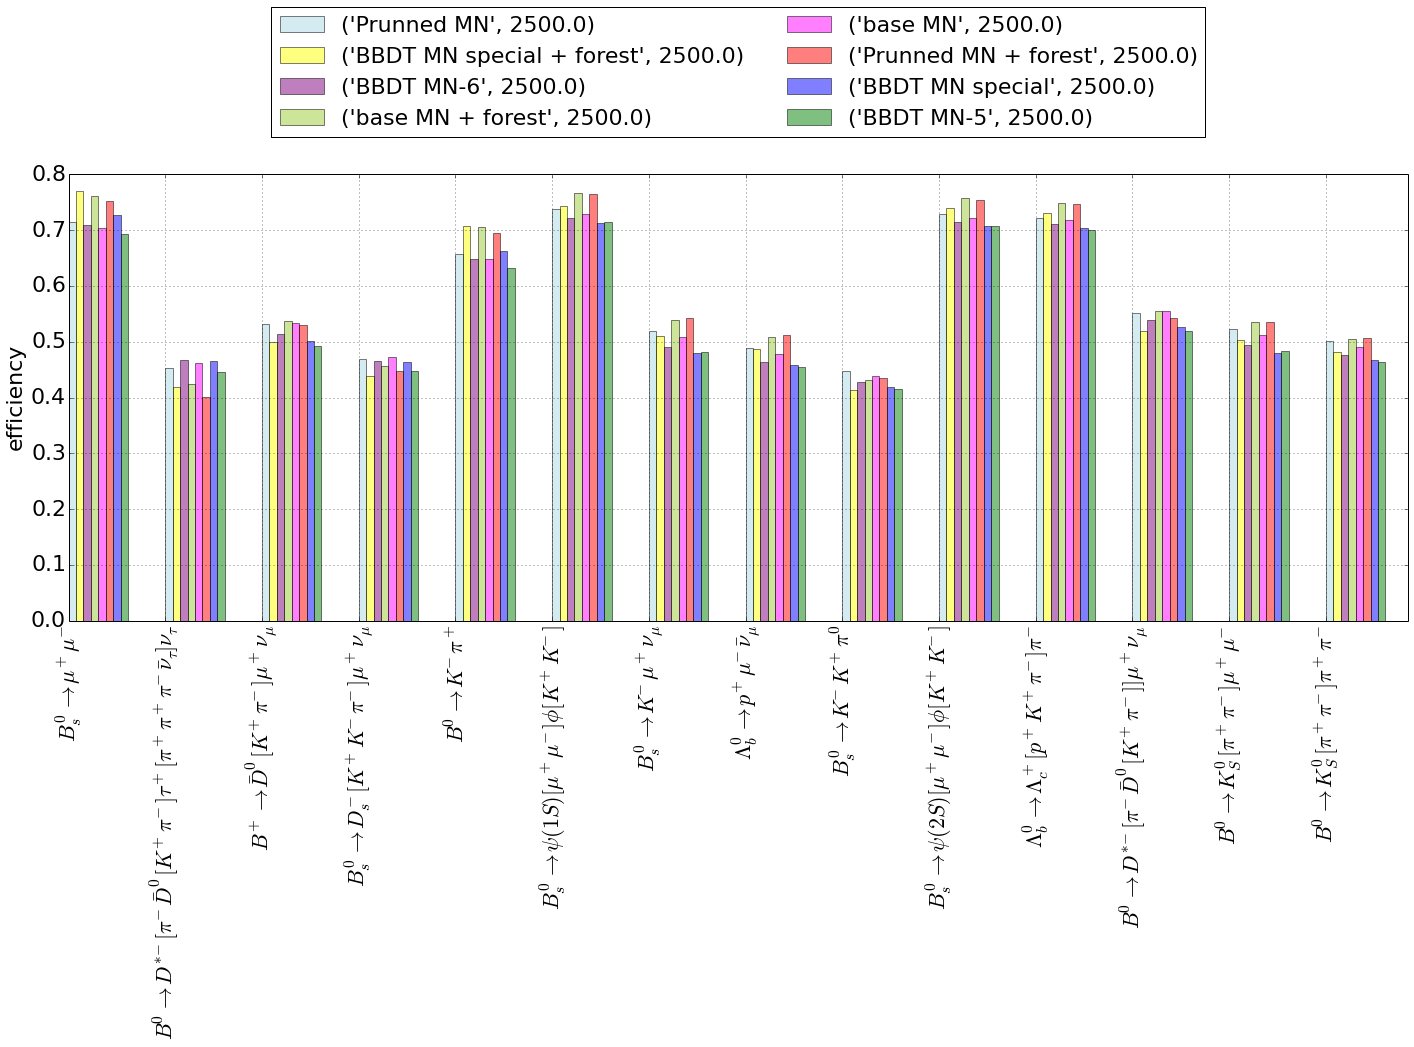

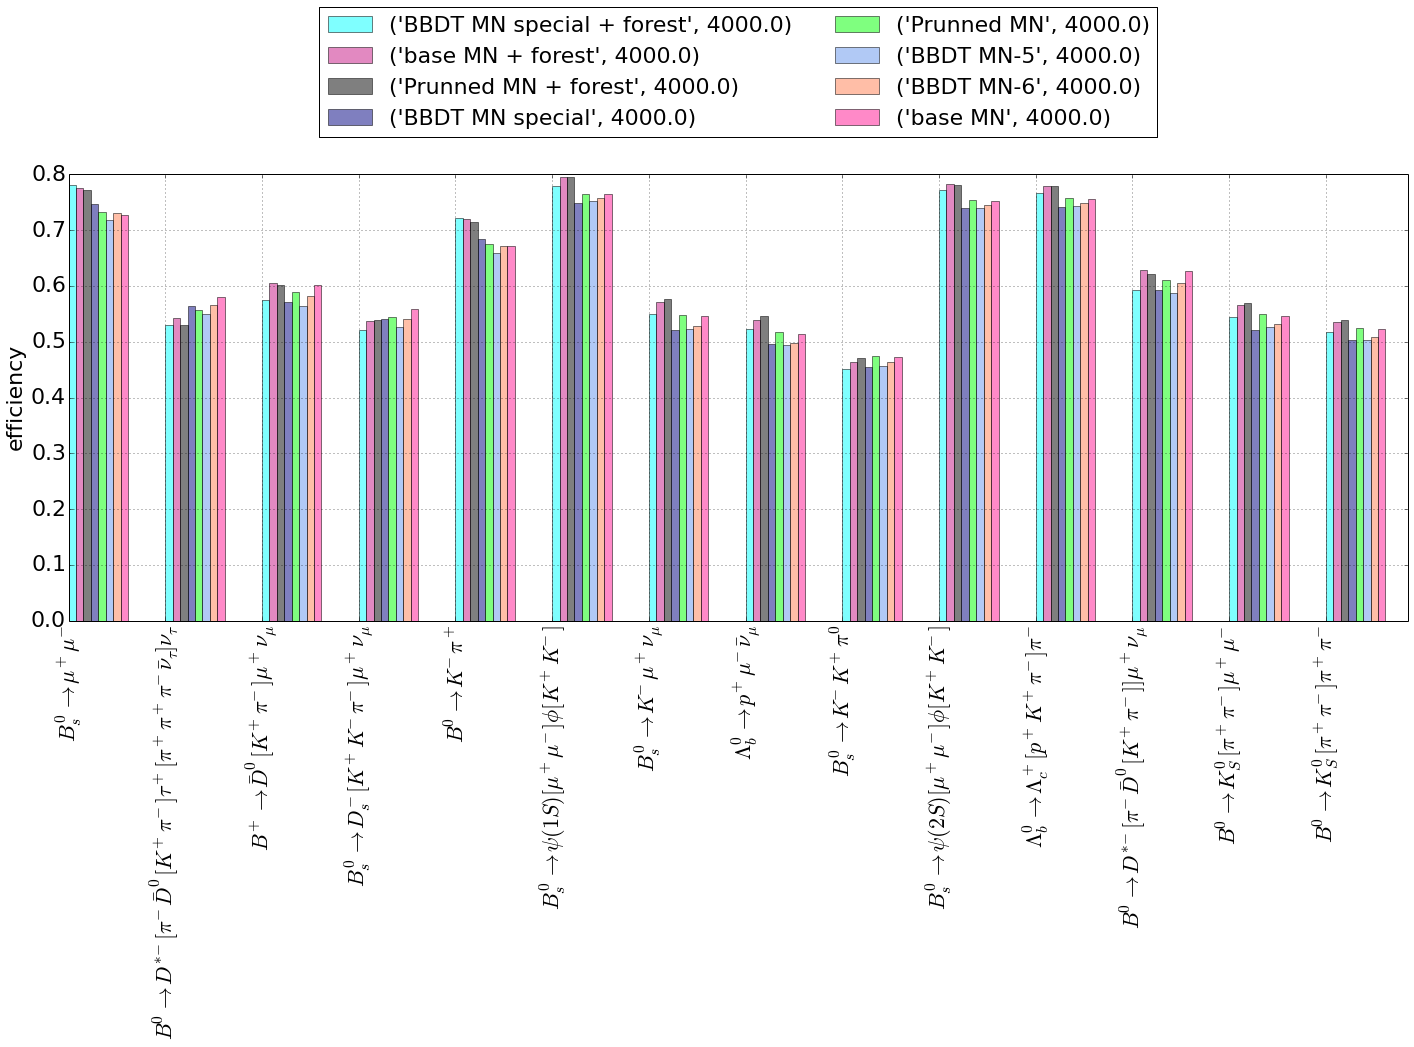

In [133]:
from rep.plotting import BarComparePlot
for r in RATE:
    new_dict = [] 
    for key, val in efficiencies.iteritems():
        if r == key[1]:
            new_dict.append((key, val))
    new_dict = dict(new_dict)        
    BarComparePlot(new_dict).plot(new_plot=True, figsize=(24, 8), ylabel='efficiency', fontsize=22)
    lgd = legend(bbox_to_anchor=(0.5, 1.4), loc='upper center', ncol=2, fontsize=22)

In [134]:
plots_all = OrderedDict()
for key, value in estimators.items():
    plots_all[key] = plot_roc_events(value, pandas.concat([test[test['signal'] == 1]] + all_channels), 
                                     test[test['signal'] == 0], key)

BBDT MN-6 AUC: 0.893047340693
BBDT MN-5 AUC: 0.891496975588
Prunned MN AUC: 0.899367387491
BBDT MN special + forest AUC: 0.894444678162
Prunned MN + forest AUC: 0.891066586762
BBDT MN special AUC: 0.896260843657
base MN + forest AUC: 0.890947087059
base MN AUC: 0.897475380098


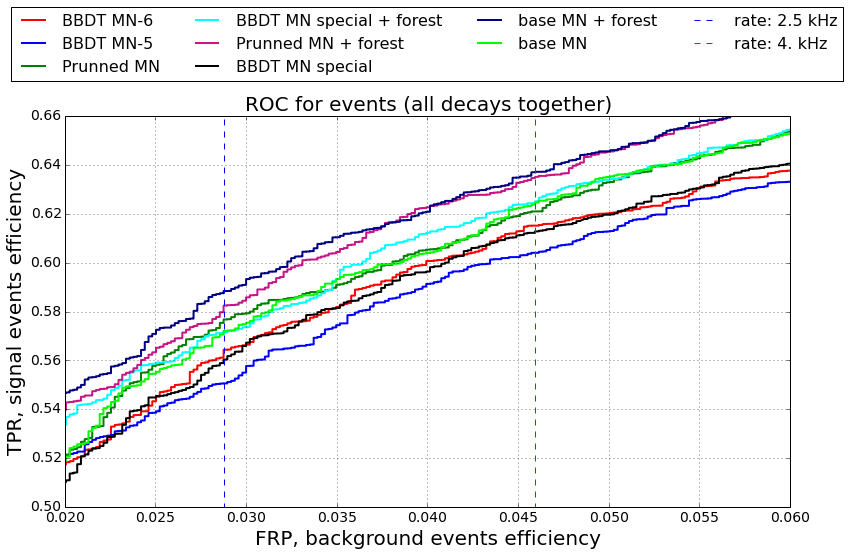

In [144]:
from rep.plotting import FunctionsPlot
FunctionsPlot(plots_all).plot(new_plot=True, xlim=(0.02, 0.06), ylim=(0.5, 0.66))
plot([1. * events_pass['2500.0-base MN'] / statistic_length(ds_test_bck)['Events']] * 2, 
     [0., 1], 'b--', label='rate: 2.5 kHz')
plot([1. * events_pass['4000.0-base MN'] / statistic_length(ds_test_bck)['Events']] * 2, 
     [0., 1], 'g--', label='rate: 4. kHz')
lgd = legend(loc='upper center', fontsize=16, bbox_to_anchor=(0.5, 1.3), ncol=4)
title('ROC for events (all decays together)', fontsize=20)
xlabel('FRP, background events efficiency', fontsize=20)
ylabel('TPR, signal events efficiency', fontsize=20)

# DIfferent rates

In [81]:
thresholds = OrderedDict()
RATE = [2000., 2500., 3000., 3500., 4000.]
for name, cl in estimators.items():
    prob = cl.predict_proba(ds_test_bck)
    thr, result = calculate_thresholds(ds_test_bck, prob, total_test_bck_events, rates=RATE)
    thresholds[name] = thr
    print name, result

BBDT MN-6 {2000.0: (0.9967790194752344, 111, 0.00199450164411622), 3000.0: (0.99547798927619391, 166, 0.002982768224534167), 4000.0: (0.99402680780929342, 222, 0.00398900328823244), 3500.0: (0.99472365991502065, 194, 0.003485885756383304), 2500.0: (0.99595672446060457, 139, 0.002497619175965357)}
BBDT MN-5 {2000.0: (0.99676111865222461, 111, 0.00199450164411622), 3000.0: (0.99559207475332101, 166, 0.002982768224534167), 4000.0: (0.99425757263704562, 222, 0.00398900328823244), 3500.0: (0.99487682163832258, 194, 0.003485885756383304), 2500.0: (0.99628784046073426, 139, 0.002497619175965357)}
BBDT MN special {2000.0: (0.99687789022772133, 111, 0.00199450164411622), 3000.0: (0.99553511016986351, 166, 0.002982768224534167), 4000.0: (0.99441421391844975, 222, 0.00398900328823244), 3500.0: (0.99498939292199462, 194, 0.003485885756383304), 2500.0: (0.99615994806063501, 139, 0.002497619175965357)}
Prunned MN {2000.0: (0.84930329512954106, 111, 0.00199450164411622), 3000.0: (0.80573534113098733,

In [82]:
train_modes_eff, statistic = result_statistic({'base MN': estimators['base MN']}, sig_train_modes_names, 
                                              test[test['signal'] == 1],
                                              thresholds, RATE, total_test_signal_events)

In [93]:
order_rate = OrderedDict()
for j in numpy.argsort([i[1] for i in train_modes_eff.keys()]):
    order_rate[train_modes_eff.keys()[j]] = train_modes_eff.values()[j]

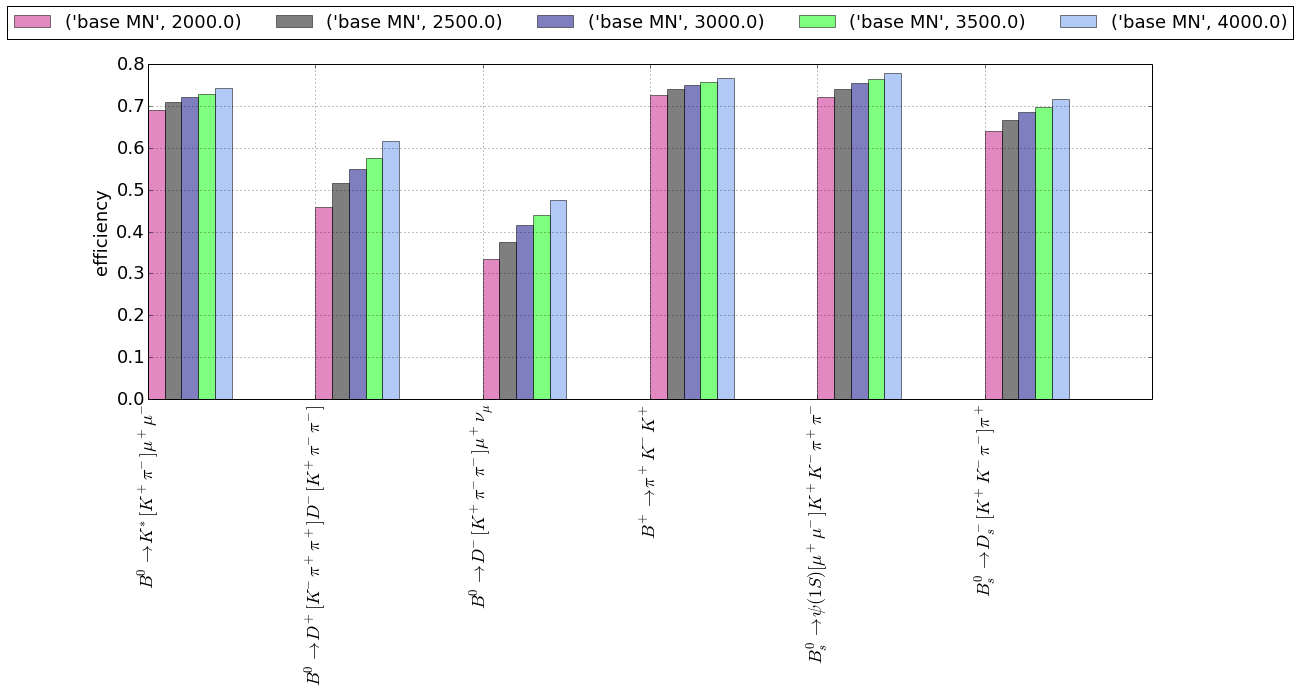

In [94]:
from rep.plotting import BarComparePlot
BarComparePlot(order_rate).plot(new_plot=True, figsize=(18, 6), ylabel='efficiency', fontsize=18)
lgd = legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=5, fontsize=18)
# plt.savefig('rates.pdf' , format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')